## 1. Introduction to Reflexion

### 1.1 Initial Response

In [1]:
import json
import os

with open('vars.json') as f:
    data = json.load(f)

openai_api_key = data["open_ai_api_key"]
langchain_api_key = data["langchain_api_key"]
# tavily_api_key = data["tavily_api_key"]
groq_api_key = data["groq_api_key"]

# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

In [2]:
# Setting up DB connection 
from langchain_community.utilities import SQLDatabase

# Docker command to run pgvector/postgres container
# docker run --name pgvector-container -e POSTGRES_USER=langchain -e POSTGRES_PASSWORD=langchain -e POSTGRES_DB=langchain -p 6024:5432 -d pgvector/pgvector:pg16
db_config = {
    'dbname': 'postgres',
    'user': 'langchain',
    'password': 'langchain',
    'host': 'localhost',
    'port': '6024'
}

connection_string = f"postgresql+psycopg://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"

db = SQLDatabase.from_uri(connection_string)
print(db.table_info)


CREATE TABLE customer (
	customer_id SERIAL NOT NULL, 
	name VARCHAR(100) NOT NULL, 
	CONSTRAINT customer_pkey PRIMARY KEY (customer_id)
)

/*
3 rows from customer table:
customer_id	name
1	John Doe
2	Jane Smith
3	Alice Johnson
*/


CREATE TABLE feedback (
	feedback_id SERIAL NOT NULL, 
	order_id INTEGER NOT NULL, 
	feedback_text TEXT, 
	CONSTRAINT feedback_pkey PRIMARY KEY (feedback_id), 
	CONSTRAINT feedback_order_id_fkey FOREIGN KEY(order_id) REFERENCES orders (order_id)
)

/*
3 rows from feedback table:
feedback_id	order_id	feedback_text
4	4	Pizza was average.
5	5	Pizza was average.
6	6	Pizza was average.
*/


CREATE TABLE orders (
	order_id SERIAL NOT NULL, 
	customer_id INTEGER NOT NULL, 
	preparation_time INTEGER NOT NULL, 
	order_date TIMESTAMP WITHOUT TIME ZONE DEFAULT CURRENT_TIMESTAMP, 
	CONSTRAINT orders_pkey PRIMARY KEY (order_id), 
	CONSTRAINT orders_customer_id_fkey FOREIGN KEY(customer_id) REFERENCES customer (customer_id)
)

/*
3 rows from orders table:
order_id	custo

In [3]:
from langchain_agents._models import get_llm

llm_llama3 = get_llm(llm_type='llama3', llm_model='llama3-70b-8192', api_key=groq_api_key)

In [4]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError
from typing import List, Optional

REFLEXION_LOOP_COUNT = 3


class Reflection(BaseModel):
    """Reflection on the generated SQL query."""
    good: str = Field(description="Critique of what is good in the given Postgres SQL query.")
    missing: str = Field(description="Critique of what is missing in the given Postgres SQL query.")
    improvements: Optional[str] = Field(description="Suggestions for improvements for the given Postgres SQL query.")

class AnswerQuestion(BaseModel):
    """Generate a SQL query to retrieve the data to answer the question. Provide a reflection on the generated query."""

    select_query: str = Field(...,
                              description="A PostgreSQL SELECT statement to retrieve the data inorder to answer the question.")
    df_columns: List[str] = Field(
        ..., description="Ordered names to give the DataFrame columns."
    )
    df_name: str = Field(
        ..., description="The name to give the DataFrame variable in downstream code."
    )
    reflection: Reflection = Field(description="Your reflection on the generated select query.")


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = []
        for attempt in range(REFLEXION_LOOP_COUNT):
            print(f"attempt: {attempt}")
            response = self.runnable.invoke(
                {"messages": state}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return response
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                                + self.validator.schema_json()
                                + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return response

In [5]:
import datetime

retrieve_from_db_prompt_string = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""
You are an expert at PostgreSQL. You have access to a PostgreSQL database 
with the following tables

{db.table_info}

Given a user question related to the data in the database, 
1. {{first_instruction}}
2. get the relevant data from the tables as a DataFrame using the {{function_name}} tool. 
3. Reflect and critique your answer based on the user question. Be severe to maximize improvement.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)

initial_answer_chain = retrieve_from_db_prompt_string.partial(
    first_instruction="Generate a SQL query to retrieve the data to answer the question.",
    function_name=AnswerQuestion.__name__,
) | llm_llama3.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [6]:
example_question = "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order."
initial = first_responder.respond([HumanMessage(content=example_question)])
initial

attempt: 0


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1pwq', 'function': {'arguments': '{"select_query":"SELECT customer_id, COUNT(order_id) as total_orders FROM orders GROUP BY customer_id ORDER BY customer_id ASC","df_columns":["customer_id","total_orders"],"df_name":"customer_orders","reflection":{"good":"The query effectively groups the orders by customer ID and counts the total orders for each customer.","improvements":"Consider adding a filter to only include customers with a minimum number of orders.","missing":"The query does not provide any additional insights beyond the total orders per customer."}}', 'name': 'AnswerQuestion'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 1916, 'total_tokens': 2068, 'completion_time': 0.482247719, 'prompt_time': 0.163654674, 'queue_time': None, 'total_time': 0.6459023930000001}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'tool_

### 1.2 Response after Reflexion

In [7]:
revise_instructions = f"""
You are an expert at PostgreSQL. You have access to a PostgreSQL database 
with the following tables

{db.table_info}

Revise your previous_select_query using given reflection.
You should use ReviseAnswer tool to give your answer.
"""


class ReviseAnswer(AnswerQuestion):
    """Revise your original PostgreSQL SELECT statement to your question. Provide an answer and 
    reflection on the revised answer."""

    new_query: str = Field(
        description="The revised PostgreSQL SELECT statement according to given reflection."
    )


revision_chain = retrieve_from_db_prompt_string.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm_llama3.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [8]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                {
                 "reflection": initial.tool_calls[0]["args"]["reflection"]
                }
            ),
        ),
    ]
)
revised

attempt: 0


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3rsc', 'function': {'arguments': '{"select_query":"SELECT customer_id, COUNT(order_id) as total_orders FROM orders GROUP BY customer_id ORDER BY customer_id ASC","df_columns":["customer_id","total_orders"],"df_name":"customer_orders","new_query":"","reflection":{"good":"The query effectively groups the orders by customer ID and counts the total orders for each customer.","improvements":"Consider adding a filter to only include customers with a minimum number of orders.","missing":"The query does not provide any additional insights beyond the total orders per customer."}}', 'name': 'ReviseAnswer'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 134, 'prompt_tokens': 2765, 'total_tokens': 2899, 'completion_time': 0.436089355, 'prompt_time': 0.257014212, 'queue_time': None, 'total_time': 0.6931035670000001}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_87cbfbbc4d', 'finish_re

## 1.3 Create Tool Node

In [10]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(reflection: dict, **kwargs):
    """Run the generated queries."""
    recommendation = reflection['missing'] + reflection['improvements']
    return [{"reflection": recommendation}]


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

## 1.4 Construct Graph

In [11]:
# TODO: Convert this into a StateGraph (now its a MessageGraph)

from typing import Literal
from langgraph.graph import END, MessageGraph, START

MAX_ITERATIONS = 3
builder = MessageGraph()
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

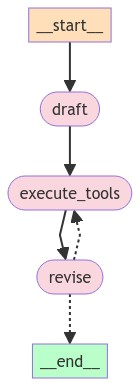

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
events = graph.stream(
    [HumanMessage(content=example_question)],
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step[-1].pretty_print()

Step 0
================================ Human Message =================================

Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.
attempt: 0
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_179c)
 Call ID: call_179c
  Args:
    select_query: SELECT customer_id, COUNT(order_id) as total_orders FROM orders GROUP BY customer_id ORDER BY customer_id ASC
    df_columns: ['customer_id', 'total_orders']
    df_name: customer_orders
    reflection: {'good': 'The query effectively groups the orders by customer ID and counts the total orders for each customer.', 'improvements': 'Consider adding a filter to only include customers with a minimum number of orders.', 'missing': 'The query does not provide any additional insights beyond the total orders per customer.'}
Step 2
================================= Tool Message =================================
Name: AnswerQ